<a href="https://colab.research.google.com/github/alexlimatds/fact_extraction/blob/main/AILA2020/FACTS_AILA_SBERT_LaBSE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Facts extraction with AILA data and SBERT (LaBSE)

- for training: the train dataset from AILA 2020. This can be obtained at https://github.com/Law-AI/semantic-segmentation;
- for test: additional train documents from AILA 2021;

There are two forms of evaluation: 5-fold cross-validation and with the test set. The data split of the cross-validation approach is done in terms of documents instead sentences.


###Installing dependencies

In [ ]:
# SBERT
!pip install -U sentence-transformers

     |████████████████████████████████| 79 kB 2.6 MB/s 
     |████████████████████████████████| 4.0 MB 13.5 MB/s 
     |████████████████████████████████| 1.2 MB 9.8 MB/s 
     |████████████████████████████████| 77 kB 3.3 MB/s 
     |████████████████████████████████| 6.6 MB 32.9 MB/s 
     |████████████████████████████████| 895 kB 38.0 MB/s 
     |████████████████████████████████| 596 kB 35.7 MB/s 
  Created wheel for sentence-transformers: filename=sentence_transformers-2.2.0-py3-none-any.whl size=120747 sha256=4f68ac2c384324857387d12eb3fe75c9cf5468b2305f10df1d97663ef19fc813
  Stored in directory: /root/.cache/pip/wheels/83/c0/df/b6873ab7aac3f2465aa9144b6b4c41c4391cfecc027c8b07e7
Successfully built sentence-transformers
  Attempting uninstall: pyyaml
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13


###Loading dataset

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)
g_drive_dir = "/content/gdrive/MyDrive/"

Mounted at /content/gdrive


In [ ]:
!rm -r data
!mkdir data
!mkdir data/train
!tar -xf {g_drive_dir}fact_extraction_AILA/train.tar.xz -C data/train
!mkdir data/test
!tar -xf {g_drive_dir}fact_extraction_AILA/test.tar.xz -C data/test

train_dir = 'data/train/'
test_dir = 'data/test/'

rm: cannot remove 'data': No such file or directory


In [ ]:
import pandas as pd
from os import listdir

def read_docs(dir_name):
  """
  Read the docs in a directory.
  Params:
    dir_name : the directory that contains the documents.
  Returns:
    A dictionary whose keys are the names of the read files and the values are 
    pandas dataframes. Each dataframe has sentence and label columns.
  """
  docs = {} # key: file name, value: dataframe with sentences and labels
  for f in listdir(dir_name):
    df = pd.read_csv(
        dir_name + f, 
        sep='\t', 
        names=['sentence', 'label'])
    docs[f] = df
  return docs

docs_train = read_docs(train_dir)
docs_test = read_docs(test_dir)

print(f'TRAIN: {len(docs_train)} documents read.')
print(f'TEST: {len(docs_test)} documents read.')

TRAIN: 50 documents read.
TEST: 10 documents read.


###Features

In [ ]:
from sentence_transformers import SentenceTransformer

sent_encoder = SentenceTransformer('sentence-transformers/LaBSE')
sent_encoder.max_seq_length = 512

Downloading:   0%|          | 0.00/391 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/190 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/114 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/2.36M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.62k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/804 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/122 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/461 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.88G [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/112 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/9.62M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/411 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/5.22M [00:00<?, ?B/s]

In [ ]:
import numpy as np

# Train features
train_features = None
train_targets = []
docs_train_features = {} # key: file id, value: numpy matrix of features
for doc_id, df in docs_train.items():
  features = sent_encoder.encode(df['sentence'].to_list())
  docs_train_features[doc_id] = features
  if train_features is None:
    train_features = features
  else:
    train_features = np.vstack((train_features, features))
  train_targets.extend(df['label'].tolist())

print(f'{train_features.shape[0]} sentences.')

9380 sentences.


In [ ]:
# Test features
test_features = None
test_targets = []
for df in docs_test.values():
  if test_features is None:
    test_features = sent_encoder.encode(df['sentence'].to_list())
  else:
    test_features = np.vstack((test_features, sent_encoder.encode(df['sentence'].to_list())))
  test_targets.extend(df['label'].tolist())

test_features.shape

(1673, 768)

### Evaluation functions

In [ ]:
# Reading the file containing the sets of trains documents and test documents by fold
train_files_by_fold = {}  # Key: fold ID, value: file names (list of string)
test_files_by_fold = {}   # Key: fold ID, value: file names (list of string)

df_folds = pd.read_csv(
  g_drive_dir + 'fact_extraction_AILA/train_docs_by_fold.csv', 
  sep=';', 
  names=['fold id', 'train', 'test'], 
  header=0)

for _, row in df_folds.iterrows():
  train_files_by_fold[row['fold id']] = row['train'].split(',')
  test_files_by_fold[row['fold id']] = row['test'].split(',')

for fold_id in train_files_by_fold.keys():
  print(f'Fold {fold_id}: \n\tTrain files: {train_files_by_fold[fold_id]} \n\tTest files: {test_files_by_fold[fold_id]}')


Fold 0: 
	Train files: ['d_44.txt', 'd_39.txt', 'd_12.txt', 'd_2.txt', 'd_7.txt', 'd_33.txt', 'd_16.txt', 'd_8.txt', 'd_42.txt', 'd_34.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_41.txt', 'd_46.txt', 'd_43.txt', 'd_50.txt', 'd_27.txt', 'd_25.txt', 'd_35.txt', 'd_45.txt', 'd_17.txt', 'd_48.txt', 'd_6.txt'] 
	Test files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt']
Fold 1: 
	Train files: ['d_22.txt', 'd_31.txt', 'd_49.txt', 'd_14.txt', 'd_29.txt', 'd_47.txt', 'd_10.txt', 'd_38.txt', 'd_28.txt', 'd_37.txt', 'd_40.txt', 'd_24.txt', 'd_36.txt', 'd_11.txt', 'd_13.txt', 'd_19.txt', 'd_18.txt', 'd_4.txt', 'd_1.txt', 'd_21.txt', 'd_15.txt', 'd_23.txt', 'd_32.txt', 'd_9.txt', 'd_5.txt', 'd_3.txt', 'd_26.txt', 'd_20.txt', 'd_30.txt', 'd_

In [ ]:
import sklearn
from sklearn.metrics import precision_recall_fscore_support

def cross_validation(trainer):
  print('### Evaluation with cross-validation ###')
  train_metrics_cross = []
  test_metrics_cross = []
  for fold_id in train_files_by_fold.keys():
    print(f'Starting fold {fold_id}')
    # train features of the current fold
    train_features_fold = None
    train_targets_fold = []
    for doc_id in train_files_by_fold[fold_id]:
      if train_features_fold is None:
        train_features_fold = docs_train_features[doc_id]
      else:
        train_features_fold = np.vstack((train_features_fold, docs_train_features[doc_id]))
      train_targets_fold.extend(docs_train[doc_id]['label'].tolist())
    #training model
    model = trainer(train_features_fold, train_targets_fold)
    # test features of the current fold
    test_features_fold = None
    test_targets_fold = []
    for doc_id in test_files_by_fold[fold_id]:
      if test_features_fold is None:
        test_features_fold = docs_train_features[doc_id]
      else:
        test_features_fold = np.vstack((test_features_fold, docs_train_features[doc_id]))
      test_targets_fold.extend(docs_train[doc_id]['label'].tolist())
    # test metrics
    predictions = model.predict(test_features_fold)
    p_test, r_test, f1_test, _ = precision_recall_fscore_support(
        test_targets_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    test_metrics_cross.append([p_test, r_test, f1_test])
    # train metrics
    predictions = model.predict(train_features_fold)
    p_train, r_train, f1_train, _ = precision_recall_fscore_support(
        train_targets_fold, 
        predictions, 
        average='binary', 
        pos_label='Facts', 
        zero_division=0)
    train_metrics_cross.append([p_train, r_train, f1_train])
  
  test_metrics_cross = np.array(test_metrics_cross)
  test_mean = np.mean(test_metrics_cross, axis=0)
  test_std = np.std(test_metrics_cross, axis=0)
  train_metrics_cross = np.array(train_metrics_cross)
  train_mean = np.mean(train_metrics_cross, axis=0)
  train_std = np.std(train_metrics_cross, axis=0)
  
  print(f'Mean precision - std deviation => train: {train_mean[0]:.4f} {train_std[0]:.4f} \t test: {test_mean[0]:.4f} {test_std[0]:.4f}')
  print(f'Mean recall - std deviation    => train: {train_mean[1]:.4f} {train_std[1]:.4f} \t test: {test_mean[1]:.4f} {test_std[1]:.4f}')
  print(f'Mean f1 - std deviation        => train: {train_mean[2]:.4f} {train_std[2]:.4f} \t test: {test_mean[2]:.4f} {test_std[2]:.4f}')


In [ ]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

test_metrics = {}

def evaluate_with_test_set(trainer):
  print('### Evaluation with the test set ###')
  # evaluation
  model = trainer(train_features, train_targets)
  predictions = model.predict(test_features)
  # Precision, Recall, F1
  t_metrics = precision_recall_fscore_support(
    test_targets, 
    predictions, 
    average='binary', 
    pos_label='Facts', 
    zero_division=0)
  test_metrics[model.__class__.__name__] = t_metrics
  print(f'Precision: {t_metrics[0]:.4f}')
  print(f'Recall:    {t_metrics[1]:.4f}')
  print(f'F-score:   {t_metrics[2]:.4f}')
  # Confusion matrix
  cm = confusion_matrix(
    test_targets, 
    predictions)
  ConfusionMatrixDisplay(cm, display_labels=['Other', 'Facts']).plot()

###Models

#### Default MLP from scikit-learn

In [ ]:
from sklearn.neural_network import MLPClassifier

def default_mlp_trainer(X, y):
  mlp = MLPClassifier(early_stopping=True, random_state=1)
  return mlp.fit(X, y)

In [ ]:
%%time
cross_validation(default_mlp_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7748 0.0487 	 test: 0.5848 0.1014
Mean recall - std deviation    => train: 0.6308 0.0403 	 test: 0.4614 0.0712
Mean f1 - std deviation        => train: 0.6952 0.0422 	 test: 0.5036 0.0316
CPU times: user 27.4 s, sys: 14.3 s, total: 41.7 s
Wall time: 21.7 s


### Evaluation with the test set ###
Precision: 0.6700
Recall:    0.7124
F-score:   0.6905
CPU times: user 7.84 s, sys: 4.25 s, total: 12.1 s
Wall time: 6.26 s


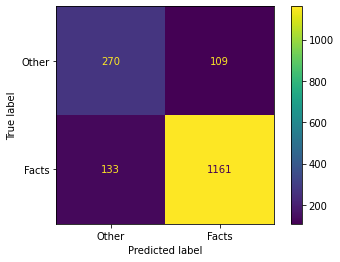

In [ ]:
%%time
evaluate_with_test_set(default_mlp_trainer)

#### Linear SVM

In [ ]:
from sklearn.svm import LinearSVC

def svm_trainer(X, y):
  svm = LinearSVC(random_state=1)
  return svm.fit(X, y)

In [ ]:
%%time
cross_validation(svm_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7357 0.0048 	 test: 0.5992 0.0983
Mean recall - std deviation    => train: 0.5368 0.0284 	 test: 0.4322 0.0692
Mean f1 - std deviation        => train: 0.6203 0.0191 	 test: 0.4898 0.0251
CPU times: user 5.45 s, sys: 686 ms, total: 6.13 s
Wall time: 5.45 s


### Evaluation with the test set ###
Precision: 0.7065
Recall:    0.5462
F-score:   0.6161
CPU times: user 1.25 s, sys: 134 ms, total: 1.38 s
Wall time: 1.25 s


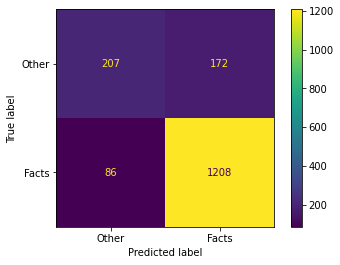

In [ ]:
%%time
evaluate_with_test_set(svm_trainer)

#### RBF SVM

In [ ]:
from sklearn.svm import SVC

def rbfsvm_trainer(X, y):
  rbfsvm = SVC(kernel='rbf', random_state=1)
  return rbfsvm.fit(X, y)

In [ ]:
%%time

cross_validation(rbfsvm_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9407 0.0094 	 test: 0.6417 0.0956
Mean recall - std deviation    => train: 0.7482 0.0210 	 test: 0.4012 0.0660
Mean f1 - std deviation        => train: 0.8331 0.0097 	 test: 0.4828 0.0296
CPU times: user 3min 18s, sys: 377 ms, total: 3min 19s
Wall time: 3min 18s


### Evaluation with the test set ###
Precision: 0.7468
Recall:    0.6148
F-score:   0.6744
CPU times: user 35.7 s, sys: 87.6 ms, total: 35.8 s
Wall time: 35.5 s


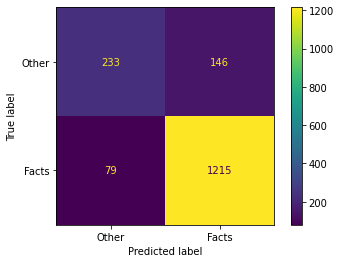

In [ ]:
%%time

evaluate_with_test_set(rbfsvm_trainer)

#### Logistic regression

In [ ]:
from sklearn.linear_model import LogisticRegression

def lr_trainer(X, y):
  logreg = LogisticRegression(solver='sag', max_iter=200, random_state=1)
  return logreg.fit(X, y)

In [ ]:
%%time

cross_validation(lr_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.7141 0.0054 	 test: 0.6217 0.0937
Mean recall - std deviation    => train: 0.4673 0.0267 	 test: 0.3984 0.0716
Mean f1 - std deviation        => train: 0.5645 0.0201 	 test: 0.4737 0.0349
CPU times: user 10 s, sys: 550 ms, total: 10.6 s
Wall time: 9.92 s


### Evaluation with the test set ###
Precision: 0.6875
Recall:    0.5224
F-score:   0.5937
CPU times: user 2.05 s, sys: 115 ms, total: 2.16 s
Wall time: 2.03 s


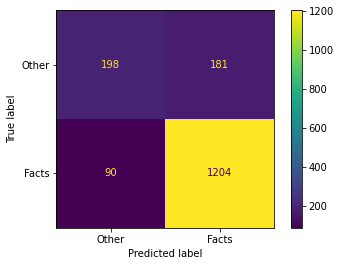

In [ ]:
%%time

evaluate_with_test_set(lr_trainer)

#### KNN

In [ ]:
from sklearn.neighbors import KNeighborsClassifier

def knn_trainer(X, y):
  knn = KNeighborsClassifier(5)
  return knn.fit(X, y)

In [ ]:
%%time

cross_validation(knn_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8324 0.0039 	 test: 0.5789 0.0907
Mean recall - std deviation    => train: 0.6726 0.0135 	 test: 0.3915 0.0633
Mean f1 - std deviation        => train: 0.7439 0.0074 	 test: 0.4562 0.0210
CPU times: user 33.3 s, sys: 4.28 s, total: 37.6 s
Wall time: 22.9 s


### Evaluation with the test set ###
Precision: 0.6943
Recall:    0.4855
F-score:   0.5714
CPU times: user 1.92 s, sys: 273 ms, total: 2.19 s
Wall time: 1.28 s


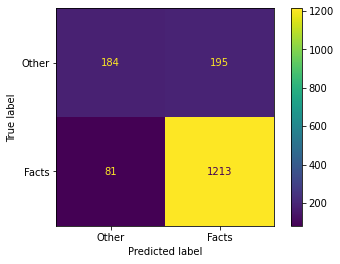

In [ ]:
%%time

evaluate_with_test_set(knn_trainer)

#### Decision Tree

In [ ]:
from sklearn.tree import DecisionTreeClassifier

def decision_tree_trainer(X, y):
  dtree = DecisionTreeClassifier(random_state=1)
  return dtree.fit(X, y)

In [ ]:
%%time

cross_validation(decision_tree_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9977 0.0007 	 test: 0.3720 0.0835
Mean recall - std deviation    => train: 0.9959 0.0012 	 test: 0.3885 0.0418
Mean f1 - std deviation        => train: 0.9968 0.0007 	 test: 0.3726 0.0393
CPU times: user 1min 13s, sys: 156 ms, total: 1min 13s
Wall time: 1min 13s


### Evaluation with the test set ###
Precision: 0.3953
Recall:    0.3984
F-score:   0.3968


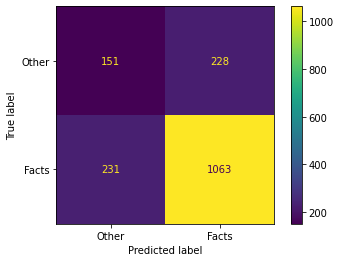

In [ ]:
evaluate_with_test_set(decision_tree_trainer)

#### Random Forest

In [ ]:
from sklearn.ensemble import RandomForestClassifier

def random_forest_trainer(X, y):
  rforest = RandomForestClassifier(random_state=1)
  return rforest.fit(X, y)

In [ ]:
cross_validation(random_forest_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.9994 0.0003 	 test: 0.7364 0.0749
Mean recall - std deviation    => train: 0.9933 0.0015 	 test: 0.1121 0.0450
Mean f1 - std deviation        => train: 0.9964 0.0008 	 test: 0.1900 0.0635


### Evaluation with the test set ###
Precision: 0.7391
Recall:    0.1346
F-score:   0.2277


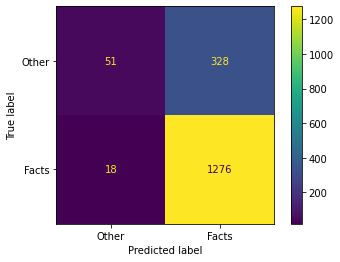

In [ ]:
evaluate_with_test_set(random_forest_trainer)

#### AdaBoost

In [ ]:
from sklearn.ensemble import AdaBoostClassifier

def adaboost_trainer(X, y):
  adab = AdaBoostClassifier(random_state=1)
  return adab.fit(X, y)

In [ ]:
cross_validation(adaboost_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.6572 0.0080 	 test: 0.5040 0.0889
Mean recall - std deviation    => train: 0.4964 0.0233 	 test: 0.3950 0.0735
Mean f1 - std deviation        => train: 0.5654 0.0170 	 test: 0.4345 0.0525


### Evaluation with the test set ###
Precision: 0.6407
Recall:    0.4987
F-score:   0.5608


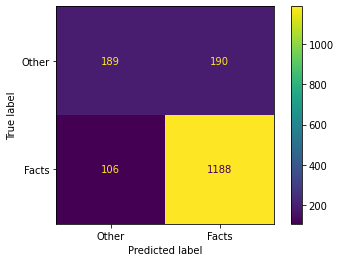

In [ ]:
evaluate_with_test_set(adaboost_trainer)

#### Naive Bayes

In [ ]:
from sklearn.naive_bayes import GaussianNB

def naive_bayes_trainer(X, y):
  nb = GaussianNB()
  return nb.fit(X, y)


In [ ]:
cross_validation(naive_bayes_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.4667 0.0200 	 test: 0.4474 0.0748
Mean recall - std deviation    => train: 0.7773 0.0094 	 test: 0.7528 0.0637
Mean f1 - std deviation        => train: 0.5829 0.0142 	 test: 0.5556 0.0535


### Evaluation with the test set ###
Precision: 0.5198
Recall:    0.8997
F-score:   0.6589


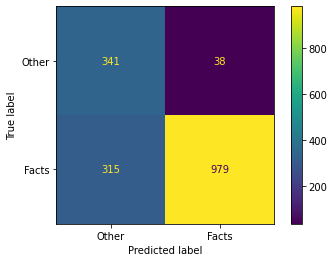

In [ ]:
evaluate_with_test_set(naive_bayes_trainer)

#### XGBoost

In [ ]:
from xgboost.sklearn import XGBClassifier
import torch

def xgboost_trainer(X, y):
  if torch.cuda.is_available():
    xgboost = XGBClassifier(objective="binary:logistic", tree_method='gpu_hist', gpu_id=0)
  else:
    xgboost = XGBClassifier(objective="binary:logistic", tree_method='hist')
  return xgboost.fit(X, y)


In [ ]:
cross_validation(xgboost_trainer)

### Evaluation with cross-validation ###
Starting fold 0
Starting fold 1
Starting fold 2
Starting fold 3
Starting fold 4
Mean precision - std deviation => train: 0.8834 0.0049 	 test: 0.6527 0.0781
Mean recall - std deviation    => train: 0.5806 0.0244 	 test: 0.3397 0.0593
Mean f1 - std deviation        => train: 0.7004 0.0172 	 test: 0.4388 0.0377


### Evaluation with the test set ###
Precision: 0.7009
Recall:    0.4142
F-score:   0.5207


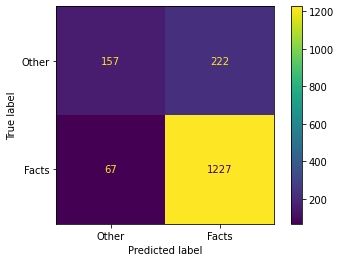

In [ ]:
evaluate_with_test_set(xgboost_trainer)

### Results

In [ ]:
from IPython.display import display, update_display

metrics_df = pd.DataFrame(columns=['Precision', 'Recall', 'F1'])
for model_name, metrics in test_metrics.items():
  metrics_df.loc[model_name] = [f'{metrics[0]:.4f}', f'{metrics[1]:.4f}', f'{metrics[2]:.4f}']
metrics_display = display(metrics_df, display_id='metrics_table')

,Precision,Recall,F1
MLPClassifier,0.6700,0.7124,0.6905
LinearSVC,0.7065,0.5462,0.6161
SVC,0.7468,0.6148,0.6744
LogisticRegression,0.6875,0.5224,0.5937
KNeighborsClassifier,0.6943,0.4855,0.5714
DecisionTreeClassifier,0.3953,0.3984,0.3968
RandomForestClassifier,0.7391,0.1346,0.2277
AdaBoostClassifier,0.6407,0.4987,0.5608
GaussianNB,0.5198,0.8997,0.6589
XGBClassifier,0.7009,0.4142,0.5207


### Reference paper:

> Paheli Bhattacharya, Shounak Paul, Kripabandhu Ghosh, Saptarshi Ghosh, and Adam Wyner. 2019. **Identification of Rhetorical Roles of Sentences in Indian Legal Judgments**. In Proc. International Conference on Legal Knowledge and Information Systems (JURIX).

